In [1]:
# !pip install numpy
# !pip install matplotlib
# !pip install graphviz
# !pip install pymetis
# !pip install networkx

In [1]:
import numpy as np

from graphviz import Digraph
import networkx as nx
import networkx.algorithms as nxa
import re
import DeBruijnDNA
import matplotlib.pyplot as plt

## De Bruijn graphのハミルトニアンパスを作成

solve 16 ising problem


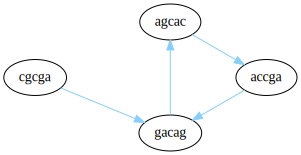

In [2]:
#seq = 'CATACACCTAA' # ゲノムシーケンス
seq = 'CAGTCA'
#seq = 'ACAAC'
seq = 'cgcgacagcaccga'

kmer_len, suffix_len = 5, 2 # 文字数は３、サフィックスは２バイト
# ゲノムシーケンスから隣接グラフとノードラvベルを生成する
adj, node_labels = DeBruijnDNA.make_debr(seq, kmer_len=kmer_len, suffix_len=suffix_len)
g, nodes = DeBruijnDNA.draw_graph(adj, node_labels, [], kmer_len = kmer_len)
g.engine = 'circo'
Q = DeBruijnDNA.to_qubo(adj) # 隣接グラフからquboを生成する
print('solve', len(Q) , 'ising problem')
g # グラフを描画する

# QAOAで実行する

In [3]:
#!pip install qiskit
#!pip install qiskit.optimization
# qiskitの必要なライブラリをimportする
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization import QuadraticProgram

/var/folders/q9/hjtxkzvd5yd3ql4lqbq_14cw0000gn/T/ipykernel_19159/12506556.py:6: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms import QAOA, NumPyMinimumEigensolver


In [4]:
# qiskitで必要なqubo式を生成する
qubo = QuadraticProgram()

term_list = ['x_'+ str(i) for i in range(len(Q))]
for term in term_list:
    qubo.binary_var(term)

# numpyのqubo行列から線形項、２次項を取り出して、qiskit用のqubo式を作成する

def get_terms(Q, term_list):
    linear = []
    quadratic = {}
    for i in range(len(Q)):
        for j in range(len(Q)):
            if i==j:
                linear.append(Q[i][j])
            else:
                quadratic[(term_list[i],term_list[j])] = Q[i][j]
    return linear, quadratic
            
linear, quad = get_terms(Q, term_list)
qubo.minimize(linear=linear, quadratic=quad)
print(qubo.prettyprint()) #qubo式を表示する

Problem name: 

Minimize
  2*x_0*x_1 + 2*x_0*x_12 + 2*x_0*x_13 + 2*x_0*x_2 + 2*x_0*x_3 + 2*x_0*x_4
  + 2*x_0*x_8 + 2*x_0*x_9 + 2*x_1*x_10 + 2*x_1*x_12 + 2*x_1*x_13 + 2*x_1*x_14
  + 2*x_1*x_2 + 2*x_1*x_3 + 2*x_1*x_4 + 2*x_1*x_5 + 2*x_1*x_8 + 2*x_1*x_9
  + 2*x_10*x_11 + 2*x_10*x_13 + 2*x_10*x_14 + 2*x_11*x_14 + 2*x_11*x_15
  + 2*x_12*x_13 + 2*x_12*x_14 + 2*x_12*x_15 + 2*x_13*x_14 + 2*x_13*x_15
  + 2*x_14*x_15 + 2*x_2*x_10 + 2*x_2*x_11 + 2*x_2*x_13 + 2*x_2*x_14 + 2*x_2*x_15
  + 2*x_2*x_3 + 2*x_2*x_5 + 2*x_2*x_6 + 2*x_2*x_9 + 2*x_3*x_10 + 2*x_3*x_11
  + 2*x_3*x_14 + 2*x_3*x_15 + 2*x_3*x_6 + 2*x_3*x_7 + 2*x_4*x_12 + 2*x_4*x_13
  + 2*x_4*x_5 + 2*x_4*x_6 + 2*x_4*x_7 + 2*x_4*x_8 + 2*x_5*x_13 + 2*x_5*x_14
  + 2*x_5*x_6 + 2*x_5*x_7 + 2*x_5*x_8 + 2*x_5*x_9 + 2*x_6*x_10 + 2*x_6*x_14
  + 2*x_6*x_15 + 2*x_6*x_7 + 2*x_6*x_9 + 2*x_7*x_10 + 2*x_7*x_11 + 2*x_7*x_15
  + 2*x_8*x_10 + 2*x_8*x_11 + 2*x_8*x_12 + 2*x_8*x_9 + 2*x_9*x_10 + 2*x_9*x_11
  + 2*x_9*x_12 + 2*x_9*x_13 - x_0 - x_1 - x_10 - x_11 - x_12 

In [5]:
# qubo式をパウリ演算子からなるイジングモデルのハミルトニアンに変換する
op, offset = qubo.to_ising() 
print("offset: {}".format(offset))
print("pauli operator:")
print(op) # パウリ演算子からなるハミルトニアンを表示する

offset: 28.0
pauli operator:
-3.5 * IIIIIIIIIIIIIIIZ
- 5.0 * IIIIIIIIIIIIIIZI
- 5.0 * IIIIIIIIIIIIIZII
- 4.0 * IIIIIIIIIIIIZIII
- 3.5 * IIIIIIIIIIIZIIII
- 4.0 * IIIIIIIIIIZIIIII
- 4.0 * IIIIIIIIIZIIIIII
- 3.0 * IIIIIIIIZIIIIIII
- 3.5 * IIIIIIIZIIIIIIII
- 4.5 * IIIIIIZIIIIIIIII
- 4.5 * IIIIIZIIIIIIIIII
- 3.5 * IIIIZIIIIIIIIIII
- 3.5 * IIIZIIIIIIIIIIII
- 4.5 * IIZIIIIIIIIIIIII
- 4.5 * IZIIIIIIIIIIIIII
- 3.5 * ZIIIIIIIIIIIIIII
+ 0.5 * IIIIIIIIIIIIIIZZ
+ 0.5 * IIIIIIIIIIIIIZIZ
+ 0.5 * IIIIIIIIIIIIIZZI
+ 0.5 * IIIIIIIIIIIIZIIZ
+ 0.5 * IIIIIIIIIIIIZIZI
+ 0.5 * IIIIIIIIIIIIZZII
+ 0.5 * IIIIIIIIIIIZIIIZ
+ 0.5 * IIIIIIIIIIIZIIZI
+ 0.5 * IIIIIIIIIIZIIIZI
+ 0.5 * IIIIIIIIIIZIIZII
+ 0.5 * IIIIIIIIIIZZIIII
+ 0.5 * IIIIIIIIIZIIIZII
+ 0.5 * IIIIIIIIIZIIZIII
+ 0.5 * IIIIIIIIIZIZIIII
+ 0.5 * IIIIIIIIIZZIIIII
+ 0.5 * IIIIIIIIZIIIZIII
+ 0.5 * IIIIIIIIZIIZIIII
+ 0.5 * IIIIIIIIZIZIIIII
+ 0.5 * IIIIIIIIZZIIIIII
+ 0.5 * IIIIIIIZIIIIIIIZ
+ 0.5 * IIIIIIIZIIIIIIZI
+ 0.5 * IIIIIIIZIIIZIIII
+ 0.5 * IIIIIIIZIIZIII

In [6]:
# イジングモデルのハミルトニアンを２次計画問題に変換
qp = QuadraticProgram()
qp.from_ising(op, offset, linear=True) 
print(qp.prettyprint())

Problem name: 

Minimize
  2*x0*x1 + 2*x0*x12 + 2*x0*x13 + 2*x0*x2 + 2*x0*x3 + 2*x0*x4 + 2*x0*x8
  + 2*x0*x9 + 2*x1*x10 + 2*x1*x12 + 2*x1*x13 + 2*x1*x14 + 2*x1*x2 + 2*x1*x3
  + 2*x1*x4 + 2*x1*x5 + 2*x1*x8 + 2*x1*x9 + 2*x10*x11 + 2*x10*x13 + 2*x10*x14
  + 2*x11*x14 + 2*x11*x15 + 2*x12*x13 + 2*x12*x14 + 2*x12*x15 + 2*x13*x14
  + 2*x13*x15 + 2*x14*x15 + 2*x2*x10 + 2*x2*x11 + 2*x2*x13 + 2*x2*x14 + 2*x2*x15
  + 2*x2*x3 + 2*x2*x5 + 2*x2*x6 + 2*x2*x9 + 2*x3*x10 + 2*x3*x11 + 2*x3*x14
  + 2*x3*x15 + 2*x3*x6 + 2*x3*x7 + 2*x4*x12 + 2*x4*x13 + 2*x4*x5 + 2*x4*x6
  + 2*x4*x7 + 2*x4*x8 + 2*x5*x13 + 2*x5*x14 + 2*x5*x6 + 2*x5*x7 + 2*x5*x8
  + 2*x5*x9 + 2*x6*x10 + 2*x6*x14 + 2*x6*x15 + 2*x6*x7 + 2*x6*x9 + 2*x7*x10
  + 2*x7*x11 + 2*x7*x15 + 2*x8*x10 + 2*x8*x11 + 2*x8*x12 + 2*x8*x9 + 2*x9*x10
  + 2*x9*x11 + 2*x9*x12 + 2*x9*x13 - x0 - x1 - x10 - x11 - x12 - x13 - x14 - x15
  - x2 - x3 - x4 - x5 - x6 - x7 - x8 - x9

Subject to
  No constraints

  Binary variables (16)
    x0 x1 x2 x3 x4 x5 x6 x7 x8 x9 x10 x

In [7]:
# qiskitのローカルシミュレータのインスタンスを生成する
quantum_instance = QuantumInstance(BasicAer.get_backend('qasm_simulator'))

/var/folders/q9/hjtxkzvd5yd3ql4lqbq_14cw0000gn/T/ipykernel_19159/669289569.py:2: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(BasicAer.get_backend('qasm_simulator'))


In [8]:
# qaoaのインスタンスを生成する
qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0.0, 0.0])
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA

/var/folders/q9/hjtxkzvd5yd3ql4lqbq_14cw0000gn/T/ipykernel_19159/3327765511.py:2: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.qaoa.QAOA`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.QAOA``. See https://qisk.it/algo_migration for a migration guide.
  qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0.0, 0.0])


In [9]:
# QAOAを実行して結果を表示する
%time qaoa_result = qaoa.solve(qubo)
print(qaoa_result.prettyprint())

CPU times: user 1min 36s, sys: 430 ms, total: 1min 36s
Wall time: 1min 36s
objective function value: -1.0
variable values: x_0=1.0, x_1=1.0, x_2=0.0, x_3=0.0, x_4=0.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=0.0, x_9=0.0, x_10=0.0, x_11=1.0, x_12=0.0, x_13=0.0, x_14=0.0, x_15=0.0
status: SUCCESS


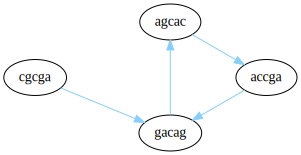

In [10]:
# 隣接グラフを描画する
g, nodes = DeBruijnDNA.draw_graph(adj, node_labels, path_spins=qaoa_result.x.tolist(), kmer_len=kmer_len)
g.engine = 'circo'
g

# ExactSolverで結果を確認する

In [43]:
# ExactSolverのインスタンスを生成する
exact_mes = NumPyMinimumEigensolver()
exact = MinimumEigenOptimizer(exact_mes)  # using the exact classical numpy minimum eigen solver

/var/folders/q9/hjtxkzvd5yd3ql4lqbq_14cw0000gn/T/ipykernel_1396/3909390844.py:2: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.numpy_minimum_eigen_solver.NumPyMinimumEigensolver`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.NumPyMinimumEigensolver``. See https://qisk.it/algo_migration for a migration guide.
  exact_mes = NumPyMinimumEigensolver()


In [44]:
# ExactSolverを実行して結果を表示する
exact_result = exact.solve(qubo)
print(exact_result.prettyprint())

objective function value: -4.0
variable values: x_0=0.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=0.0, x_6=0.0, x_7=1.0, x_8=1.0, x_9=0.0, x_10=0.0, x_11=0.0, x_12=0.0, x_13=1.0, x_14=0.0, x_15=0.0
status: SUCCESS


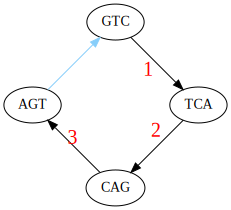

In [45]:
# 隣接グラフを描画する
g, nodes = DeBruijnDNA.draw_graph(adj, node_labels, path_spins=exact_result.x.tolist(), kmer_len=kmer_len)
g.engine = 'circo'
g